In [1]:
import numpy as np
import pandas as pd
from DataProcessing import Data
import matplotlib.pyplot as plt
import seaborn as sns                       #visualisation
sns.set_theme(color_codes=True)

# 1. Get Data 

## 1.1. Get Data from folder

In [2]:
d = Data()
d.get_index_names()

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']


['AAPL',
 'ORCL',
 'GOOGL',
 'AMZN',
 'BK',
 'LIFE',
 'T',
 'XOM',
 'VHM',
 'CTR',
 'FPT',
 'MBB']

In [3]:
chosen_index = 'GOOGL'

In [4]:
d.preprocess(chosen_index)

Processing GOOGL.csv
Saved GOOGL data at data/processed/GOOGL.csv


In [5]:
df = d.get_data(chosen_index)

In [6]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MFI', 'EMA',
       'SO', 'MACD', 'Next Day Price'],
      dtype='object')

# 2. Train model

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  train_test_split

In [8]:
X = df[df.columns[1:10]].values
Y = df[df.columns[10]].values

In [9]:
df.columns[1:10]

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MFI', 'EMA', 'SO'], dtype='object')

In [10]:
# plt.plot(df['RSI'],color='pink',label='RSI')
# plt.plot(Y,color='green',label='Close Price')
# plt.plot(df['EMA'],color='blue',label='EMA')
# # legend
# plt.legend(loc='best')
# plt.title(f'{chosen_index}')
# plt.show()

## 2.1. Split data

### 2.1.2. Unchronologically

In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=37)

### 2.1.2. Chronologically

In [12]:
TRAIN_PERCENT = 0.8
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

## 2.2. Train model

In [13]:
from helper import prepare_data
from sklearn.model_selection import GridSearchCV

def train_model(index):
    X_train, Y_train, X_test, Y_test = prepare_data(index)
    model = RandomForestRegressor()

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 5, 6],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    model = GridSearchCV(model, param_grid, cv = 3, n_jobs = -1, verbose = 2)
    model.fit(X_train,Y_train)
    print("Best parameters found: ", model.best_params_)

    model.score(X_test,Y_test)
    return model

model = train_model(chosen_index)

X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


# Evaluation

In [14]:
from helper import calculate_loss
X_train, Y_train, X_test, Y_test = prepare_data(chosen_index)
calculate_loss(model, X_test, Y_test)


X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
Calculating loss for model GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=2)...
Mean Squared Error: 7.056124963549652
R-squared: 0.963129466344214
Root Mean Squared Error: 2.656336756427854
Mean Absolute Percentage Error: 0.017337297314288343
Mean Absolute Error: 2.1199267484810163


(7.056124963549652,
 0.963129466344214,
 2.656336756427854,
 0.017337297314288343,
 2.1199267484810163)

## Plot Result

In [15]:
Y_predict = model.predict(X_test)

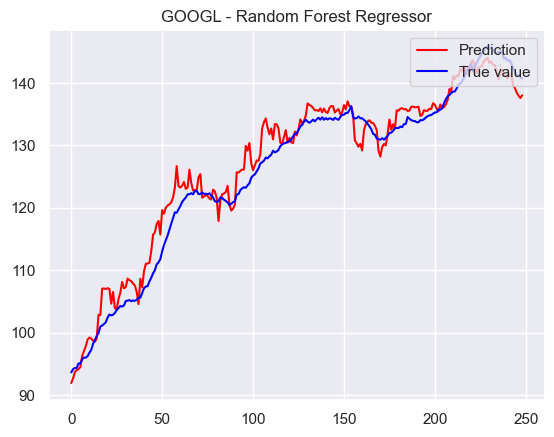

In [16]:
plt.plot(Y_predict,color='red',label='Prediction')
plt.plot(Y_test,color='blue',label='True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - Random Forest Regressor')
plt.show()

## Save results

In [17]:
import time
from helper import calculate_loss, prepare_data

mae = []
mse = []
r2 = []
rmse = []
mape = []
avg_runtime = 0

list_tickers = d.get_sp500_tickers()
# track run time

for ticker in list_tickers:
    start = time.time()
    X_train, Y_train, X_test, Y_test = prepare_data(ticker)

    # call model
    model = train_model(ticker)

    # predictions = model.predict(X_test)
    mse_, r2_, rmse_, mape_, mae_ = calculate_loss(model, X_test, Y_test)
    mae.append(mae_)
    mse.append(mse_)
    r2.append(r2_)
    rmse.append(rmse_)
    mape.append(mape_)

    end = time.time()
    avg_runtime += (end-start)

mae = np.mean(list(mae))
mse = np.mean(list(mse))
r2 = np.mean(list(r2))
rmse = np.mean(list(rmse))
mape = np.mean(list(mape))
avg_runtime = avg_runtime/len(list_tickers)

with open('output/evaluation.csv', 'a') as f:
    f.write(f'Random Forest,{mae},{mse},{r2},{rmse},{mape},{avg_runtime}\n')

X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
Fitting 3 folds for each of 108 candidates, totalling 324 fits


Best parameters found:  {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Calculating loss for model GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=2)...
Mean Squared Error: 232.99252360618553
R-squared: -0.8617662928786418
Root Mean Squared Error: 15.264092623087215
Mean Absolute Percentage Error: 0.07171925670415906
Mean Absolute Error: 13.20826592777162
X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
X_train: (996, 9), Y_train: (996,), X_test: (249, 9), Y_test: (249,)
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'max_depth': 6, 'max_features': 'sqrt', '